### This model is designed for a small dataset like CIFAR-10. 
#### The first conv2d layer is replaced by a 3x3 conv2d layer, the maxpool and the classifier are removed.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import resnet50

### SimCLR model for a small dataset (CIFAR-10)
class ModelSimCLR(nn.Module):
    def __init__(self, feature_dim=128):
        super(ModelSimCLR, self).__init__()

        self.f = []
        for name, module in resnet50().named_children():
            #print(name, module)
            if name == 'conv1':
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            if not isinstance(module, nn.Linear) and not isinstance(module, nn.MaxPool2d):
                self.f.append(module)
        # encoder
        self.f = nn.Sequential(*self.f)
        # projection head
        self.g = nn.Sequential(nn.Linear(2048, 512, bias=False), nn.BatchNorm1d(512),
                               nn.ReLU(inplace=True), nn.Linear(512, feature_dim, bias=True))

    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.g(feature)
        return F.normalize(feature, dim=-1), F.normalize(out, dim=-1)
    

model = ModelSimCLR()
#print (model)


### The vectorized implementation of the SimCLR loss. 
### Task 1: Create a naive implementation of the loss and compare the results. 

In [11]:
class LossSimCLR(nn.Module):
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
            
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)
        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)
    
        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * self.batch_size)
        return loss

contrastive_loss = LossSimCLR(3, 1.0)

I = torch.tensor([[1.0, 2.0], [3.0, -2.0], [1.0, 5.0]], requires_grad=True)
J = torch.tensor([[1.0, 0.75], [2.8, -1.75], [1.0, 4.7]], requires_grad=True)
contrastive_loss(I, J)

tensor(1.1327, grad_fn=<DivBackward0>)

In [19]:
from torchvision.datasets import STL10, CIFAR10
import torchvision.transforms.functional as tvf
from torchvision import transforms
import numpy as np

stl10_unlabeled = STL10(".", split="unlabeled", download=True)
cifar10_train = CIFAR10(".", train=True, download=True)

Files already downloaded and verified


100%|██████████| 170498071/170498071 [00:15<00:00, 11276134.97it/s]


Extracting ./cifar-10-python.tar.gz to .


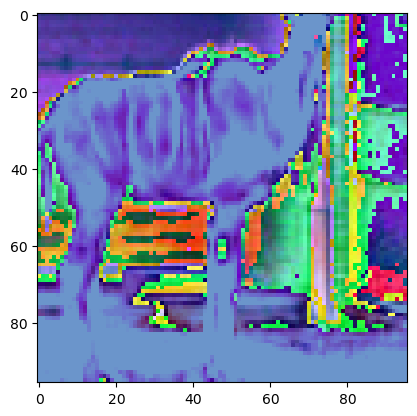

In [4]:
import torchvision
import PIL
import torchvision.transforms.functional as tvf

class TransformsSimCLR:
    """
    A stochastic data augmentation module that transforms any given data example randomly
    resulting in two correlated views of the same example,
    denoted x ̃i and x ̃j, which we consider as a positive pair.
    """

    def __init__(self, size):
        self.preprocess = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        s = 1
        color_jitter = torchvision.transforms.ColorJitter(
            0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s
        )
        self.train_transform = torchvision.transforms.Compose(
            [   
                
                torchvision.transforms.RandomResizedCrop(size=size),
                torchvision.transforms.RandomHorizontalFlip(),  # with 0.5 probability
                torchvision.transforms.RandomApply([color_jitter], p=0.8),
                torchvision.transforms.RandomGrayscale(p=0.2),
                torchvision.transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]
        )

        self.test_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(size=size),
                torchvision.transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]
        )
    

    def __call__(self, x):
        x_prep = self.preprocess(x)
        return self.train_transform(x), self.train_transform(x)
    

transform = TransformsSimCLR(96)
x = stl10_unlabeled[0][0]

x1, x2 = transform(x)
import matplotlib.pyplot as plt
to_show_x1 = tvf.to_pil_image (x1)
plt.imshow(to_show_x1)
plt.show()



In [34]:
from torch.utils.data import Dataset, DataLoader

class DatasetWrapper(Dataset):
   def __init__(self, ds: Dataset, target_size=(96, 96)):
        super().__init__()
        self.ds = ds
        self.target_size = target_size
        self.transform = TransformsSimCLR(target_size[0])

   def __len__(self): 
       return len(self.ds)
   
   def __getitem__(self, idx):
        img, target = self.ds[idx]
        t1, t2 = self.transform(img)
        return t1,t2, torch.tensor(target)
ds = DatasetWrapper(stl10_unlabeled) 

train_loader = DataLoader(ds, batch_size=1, shuffle=True, num_workers=16, pin_memory=True,
                              drop_last=True)

ds1 = DatasetWrapper(cifar10_train, target_size=(32, 32))
train_loader1 = DataLoader(ds1, batch_size=1, shuffle=True, num_workers=16, pin_memory=True,
                              drop_last=True)
iterator = iter(train_loader)
x1, x2, target = next(iterator)
print(x1.shape)


torch.Size([1, 3, 96, 96])


In [12]:
from torchvision.models.resnet import resnet50

### SimCLR model for a bigger dataset (STL-10)
class SimCLRNetwork1(nn.Module):               
    def __init__(self, embedding_size=128):
        super().__init__()
        
        base_model = resnet50()
        internal_embedding_size = base_model.fc.in_features
        base_model.fc = nn.Identity()
        self.embedding = base_model
        
        self.projection = nn.Sequential(
            nn.Linear(in_features=internal_embedding_size, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=embedding_size)
        )

    def calculate_embedding(self, image):
        return self.embedding(image)

    def forward(self, X):
        image = X
        embedding = self.calculate_embedding(image)
        projection = self.projection(embedding)
        return embedding, projection
    
network = SimCLRNetwork1()

iterator = iter(train_loader)
x1, x2, target = next(iterator)
print(x1.shape, x2.shape)
emb_i, proj_i = network(x1)
print(emb_i.shape)
print(proj_i.shape)

emb_j, proj_j = network(x2)
criterion = LossSimCLR(batch_size=1, temperature=0.5)
loss = criterion(proj_i, proj_j)

torch.Size([1, 3, 96, 96]) torch.Size([1, 3, 96, 96])
torch.Size([1, 2048])
torch.Size([1, 128])


In [38]:
import gc
#del network
gc.collect()
torch.cuda.empty_cache()

In [39]:

import torch.optim as optim
batch_size = 128

criterion = LossSimCLR(batch_size=batch_size, temperature=0.5).to("cuda")
train_loader = DataLoader(ds1, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True,
                              drop_last=True)
epochs = 10

#network = SimCLRNetwork1().to("cuda")
network = ModelSimCLR().to("cuda")
optimizer = optim.Adam(network.parameters(), lr=1e-3, weight_decay=1e-6)


for epoch in range(epochs):
    network.train()
    loss_epoch = 0
    for i, (x_i, x_j, _) in enumerate(train_loader):
        
        x_i = x_i.to("cuda")
        x_j = x_j.to("cuda")

        optimizer.zero_grad()
        
        emb_i, proj_i = network(x_i)
        emb_j, proj_j = network(x_j)
        loss = criterion(proj_i, proj_j)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()
    loss_epoch /= len(train_loader)
    print(f"Epoch {epoch}, loss: {loss_epoch}")
     

Epoch 0, loss: 5.286667774885129
Epoch 1, loss: 4.967713128603422
Epoch 2, loss: 4.688632901509603
Epoch 3, loss: 4.568661123667008
Epoch 4, loss: 4.496142190541977
Epoch 5, loss: 4.436927133951432
Epoch 6, loss: 4.402772953571417
Epoch 7, loss: 4.376853051552406
Epoch 8, loss: 4.353218160531459
Epoch 9, loss: 4.3320516378451615
